In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import shutil 
import pandas as pd
import PIL
import cv2
import glob
from tensorflow.keras.preprocessing import image
from PIL import Image

In [2]:
citizen_dir = './citizen'
citizen_dir2 = './citizen2/train'
mugshot_dir = './mugshot/front/front'

In [3]:
print('citizen dataset : ',len(os.listdir(citizen_dir)))
print('citizen2 dataset : ',len(os.listdir(citizen_dir2)))
print()
print('total citizen dataset : ', len(os.listdir(citizen_dir)) +len(os.listdir(citizen_dir2)))
print('mugshot dataset : ',len(os.listdir(mugshot_dir)))

citizen dataset :  24109
citizen2 dataset :  86744

total citizen dataset :  110853
mugshot dataset :  68492


# 1. Get Frontal Face

In [7]:
import dlib
#http://blog.naver.com/PostView.nhn?blogId=dic1224&logNo=221073987368&parentCategoryNo=&categoryNo=248&viewDate=&isShowPopularPosts=false&from=postView
def get_frontal_face(img_dir, output_dir):
    path_list = os.listdir(img_dir)
    for i,path in enumerate(path_list):
        if path[-3:]=='zip':
            continue

        image = cv2.imread(img_dir+'/'+path)
        face_detector = dlib.get_frontal_face_detector()
        try:
            faces = face_detector(np.array(image))
        except:
            continue
        #정면 얼굴이 하나 이상이라면 가장 사이즈가 큰 얼굴만 선택
        if len(faces)>1:
            size_list = []
            for face in faces:
                size = (face.bottom()-face.top())*(face.right()-face.left())
                size_list.append(size)
            face = faces[np.argmax(size_list)]
        elif len(faces)==1:
            face = faces[0]
        else:
            continue
        front_face = np.array(image)[face.top():face.bottom(),face.left():face.right()]
        output = output_dir+'/'+path
        try:
            cv2.imwrite(output,front_face)
        except:
            continue

In [8]:
get_frontal_face(citizen_dir2,'./frontal_face_set/citizen')

In [9]:
get_frontal_face(mugshot_dir,'./frontal_face_set/mugshot')

In [10]:
frontal_ctz_dir = './frontal_face_set/citizen'
frontal_mgs_dir = './frontal_face_set/mugshot'

In [12]:
print('cropped citizen dataset : ',len(os.listdir(frontal_ctz_dir)))
print('cropped mugshot dataset : ',len(os.listdir(frontal_mgs_dir)))

cropped citizen dataset :  85846
cropped mugshot dataset :  66979


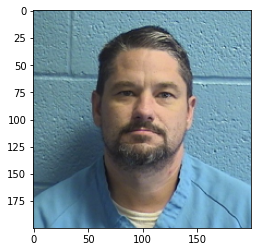

In [11]:
frontal = os.listdir('./frontal_face_set/mugshot')[4] 
orginal = mugshot_dir+'/'+frontal
image = Image.open(orginal)
resize_image = image.resize((200, 200))
pix = np.array(resize_image)
plt.imshow(pix)

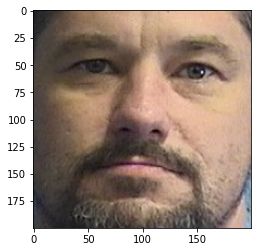

In [12]:
frontal_face = './frontal_face_set/mugshot'+'/'+frontal
image = Image.open(frontal_face)
resize_image = image.resize((200, 200))
pix = np.array(resize_image)
plt.imshow(pix)

# 2. Remove Other Race, Age, Gender - Citizen

In [13]:
ctz_img_name = [[],[]] #citizen dir / citizen dir 2
for img in os.listdir(frontal_ctz_dir):
    if len(img)<10:
        ctz_img_name[1].append(img)
    else:
        ctz_img_name[0].append(img)

In [14]:
# [[citizien directory 1], [citizen directory 2]]
ctz_used1 = [[],[]] 
ctz_used2 = [[],[]] 

#citizen dir 1
for index,img in enumerate(ctz_img_name[0]):
    try:
        #male and age more than 20 and less than 90 and only male
        if int(img.split('_')[0])>=20 and int(img.split('_')[0])<=90 and int(img.split('_')[1])==0:  
            if int(img.split('_')[2])==0: #white 
                ctz_used1[0].append(img)
            elif int(img.split('_')[2])==1:#black
                ctz_used1[1].append(img)
    except:
        continue

In [23]:
#citizen dir 2
ctz_img_name_full = []
for name in ctz_img_name[1]:
    ctz_img_name_full.append('train/'+name)

In [17]:
citizen2_data = pd.read_csv('./fairface_label_train.csv')
citizen2_data = pd.merge(pd.DataFrame(ctz_img_name_full),citizen2_data,how='left',left_on=0,right_on='file')
citizen2_data = citizen2_data.drop([0],axis=1)

In [28]:
citizen2_data.age = citizen2_data.age.str.replace('more than 70','70-')

In [29]:
# ex) 20-30 -> 20
citizen2_data['Age'] = citizen2_data.age.str.split('-').str[0].astype('int64') 

In [41]:
ctz_used2[0] = list(citizen2_data[(citizen2_data['race']=='White')&(citizen2_data['Age']>=20)&(citizen2_data['gender']=='Male')]['file'])
ctz_used2[1] = list(citizen2_data[(citizen2_data['race']=='Black')&(citizen2_data['Age']>=20)&(citizen2_data['gender']=='Male')]['file'])

# 2. Remove Other Race, Age, Gender - Mugshot

In [18]:
import pandas as pd
mugshot_data = pd.read_csv('./mugshot/person.csv')

#remove '.jpg'
for i in range(len(cropped_mgs)):
    cropped_mgs[i] = cropped_mgs[i][:-4] 

In [21]:
#information for frontal face only
cropped_mgs = list(os.listdir(frontal_mgs_dir))
drop_id = []
for i in mugshot_data.index:
    mgs_id = i.split(';')[0]
    if mgs_id not in cropped_mgs:
        drop_id.append(i)
        
mugshot_data = mugshot_data.drop(drop_id)

In [25]:
mugshot_id = []
for i in mugshot_data.index:
    mugshot_id.append(i.split(';')[0])
    
mgs_used = [[],[]]
for index,data in enumerate(mugshot_data.iloc[:,0]):
    try:
        race = data.split(';')[6]
        age = (2020-int(data.split(';')[1].split('/')[2]))
        gender = data.split(';')[4]
        img = mugshot_data.index[index].split(';')[0]
        if age>=20 and age<=90 and gender=='Male':
            if race=='White':
                mgs_used[0].append(img)
            elif race=='Black':
                mgs_used[1].append(img)
    except:
        continue

# 3. Preprocess Race Ratio

In [32]:
#for same directory name 
for i in range(len(ctz_used2[0])):
    ctz_used2[0][i] = ctz_used2[0][i].split('/')[1]
for i in range(len(ctz_used2[1])):
    ctz_used2[1][i] = ctz_used2[1][i].split('/')[1]

In [33]:
ctz_used = [[],[]]
ctz_used[0] = ctz_used1[0] + ctz_used2[0]
ctz_used[1] = ctz_used1[1] + ctz_used2[1]

In [34]:
#following U.S. democratic ratio between white and black
white_pct = (8*0.82 + 2) / 10
black_pct = (8*0.18) / 10

In [35]:
import random 
'''
all white used
black was sampled following number of white images
'''
ctz_used[1] = random.sample(ctz_used[1],int(len(ctz_used[0]) * black_pct/white_pct))

In [36]:
ctz_total = len(ctz_used[0]) + len(ctz_used[1])
ctz_total

11060

In [27]:
#following mugshot data race ratio
mgs_white_pct = 8 * (w / (w+b)) / 10
mgs_black_pct = (8 * (b / (w+b)) + 2) / 10

In [38]:
mgs_used[0] = random.sample(mgs_used[0],int(ctz_total*mgs_white_pct))
mgs_used[1] = random.sample(mgs_used[1],int(ctz_total*mgs_black_pct))

In [39]:
mgs_total = len(mgs_used[0]) + len(mgs_used[1])
mgs_total

11059

In [72]:
'''
train test split
test case will be changed : citizen white -> black
                            mugshot black -> white

'''
from sklearn.model_selection import train_test_split

#citizen white
X_train, X_test, Y_train, Y_test= train_test_split(ctz_used[0], np.zeros(shape=len(ctz_used[0])), test_size=0.2, shuffle=True,random_state=34)
X_train = X_train + ctz_used[1]

np.save('./test_set/train_citizen/img_path.npy', np.array(X_train))
np.save('./test_set/test_citizen_white_to_black/img_path.npy', np.array(X_test))  #나중에 black으로 skin change
print(len(X_train), len(X_test))

9166 1894


In [73]:
#mugshot_black
X_train, X_test, Y_train, Y_test= train_test_split(mgs_used[1], np.zeros(shape=len(mgs_used[1])), test_size=0.2, shuffle=True,random_state=34)
X_train = X_train + mgs_used[0]

np.save('./test_set/train_mugshot/img_path.npy', np.array(X_train))
np.save('./test_set/test_mugshot_black_to_white/img_path.npy', np.array(X_test)) #나중에 white로 skin change
print(len(X_train), len(X_test))

9449 1610


In [2]:
citizen_train = np.load('./test_set/train_citizen/img_path.npy')
mugshot_train = np.load('./test_set/train_mugshot/img_path.npy')

In [41]:
citizen_test = np.load('./test_set/test_citizen_white_to_black/img_path.npy')
mugshot_test= np.load('./test_set/test_mugshot_black_to_white/img_path.npy')

In [42]:
print('Number of training image - citizen: ',citizen_train.shape)
print('Number of training image - mugshot : ',mugshot_train.shape)

Number of training image - citizen:  (9166,)
Number of training image - mugshot :  (9449,)


In [43]:
print('Number of test image - citizen : ',citizen_test.shape)
print('Number of test image - mugshot : ',mugshot_test.shape)

Number of test image - citizen :  (1894,)
Number of test image - mugshot :  (1610,)
